<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [4]</a>'.</span>

## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizontal_wavelet_indoor_coco.ipynb


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

print(CWD, os.getcwd())
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/gray /Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/gray


'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


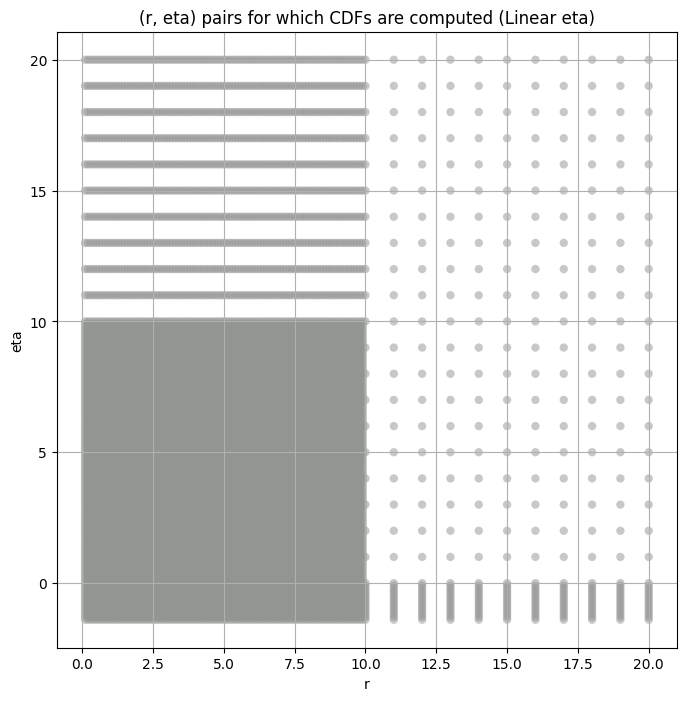

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.407840e+07  2.168831e+07  2.656773e+07   0.461436    0.050193   
3      5.192924e+06  4.881462e+06  5.512114e+06   1.550051    1.186425   
4      1.119893e+06  1.053084e+06  1.188511e+06   3.461348    2.873582   
5      2.094513e+05  1.953325e+05  2.241483e+05   5.254725    4.462294   
6      3.787319e+04  3.475236e+04  4.113391e+04   8.857376    7.467968   
7      6.625385e+03  5.973334e+03  7.328550e+03  13.585444   11.134627   
8      1.253688e+03  1.105452e+03  1.416207e+03  20.776464   16.477352   
9      2.695679e+02  2.335772e+02  3.089436e+02  27.743181   21.335247   

       kurt_upper  total_samples  
layer                             
2        0.936050         1604.0  
3        1.950193         6416.0  
4        4.113647        25664.0  
5        6.151662       102656.0  
6       10.460917       410624.0  
7       16.512316      1642496.0  
8       26.031052      6569984.0  
9       36.427760     26279936.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      2.407840e+07   2.407840e+07    1.927436e+07    1.661182e+07   
3      5.192924e+06   5.192924e+06    4.673814e+06    4.354320e+06   
4      1.119893e+06   1.119893e+06    1.063398e+06    1.024895e+06   
5      2.094513e+05   2.094513e+05    2.053045e+05    2.021460e+05   
6      3.787319e+04   3.787319e+04    3.684662e+04    3.606651e+04   
7      6.625385e+03   6.625385e+03    6.378965e+03    6.196830e+03   
8      1.253688e+03   1.253688e+03    1.190242e+03    1.145294e+03   
9      2.695679e+02   2.695679e+02    2.527357e+02    2.411144e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        1.456745e+07     1.283681e+07     9.973922e+06     7.757242e+06   
3        4.095576e+06     3.876299e+06     3.509532e+06     3.200022e+06   
4        9.935982e+05     9.663378e+05     9.184202e+05     8.781265e+05   
5        1.993957e+05     1.969068e+05     1.923966e+05     1.883201e+05   
6        3.538395e+04     3.476857e+04     3.367623e+04     3.271500e+04   
7        6.041407e+03     5.903775e+03     5.664606e+03     5.459319e+03   
8        1.107488e+03     1.074411e+03     1.017831e+03     9.698668e+02   
9        2.314816e+02     2.231397e+02     2.090506e+02     1.973348e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         6.059188e+06     4.766715e+06     3.695548e+06     1.492725e+06  
3         2.932447e+06     2.697272e+06     2.490793e+06     1.981344e+06  
4         8.425525e+05     8.103880e+05     7.809409e+05     7.049258e+05  
5         1.845916e+05     1.811311e+05     1.779025e+05     1.691669e+05  
6         3.184599e+04     3.104735e+04     3.030783e+04     2.835702e+04  
7         5.276277e+03     5.109902e+03     4.957267e+03     4.563918e+03  
8         9.280339e+02     8.908383e+02     8.573466e+02     7.730154e+02  
9         1.872938e+02     1.785002e+02     1.706810e+02     1.514164e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.09544861808757132 24078400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.10232739535625018 19274358.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.10983773588283902 16611822.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.1207114330833644 14567449.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.13112755021823008 12836806.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.1597525799362437 9973922.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.1889707828559416 7757242.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.21678320402066686 6059188.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.24376391895575222 4766715.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.2731341949145222 3695548.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.3653240661832162 1492725.1
Number of samples: 1604, Without approximation : 1604.0


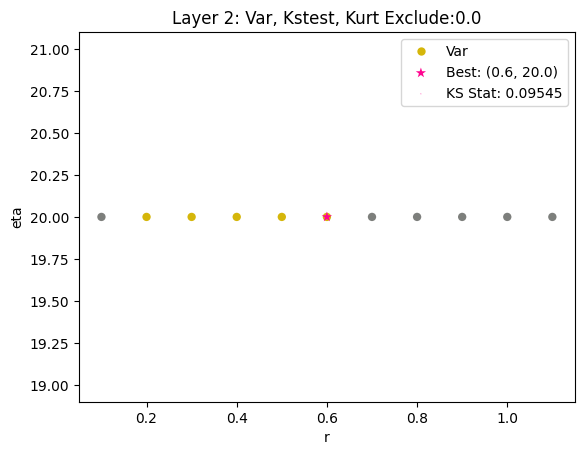

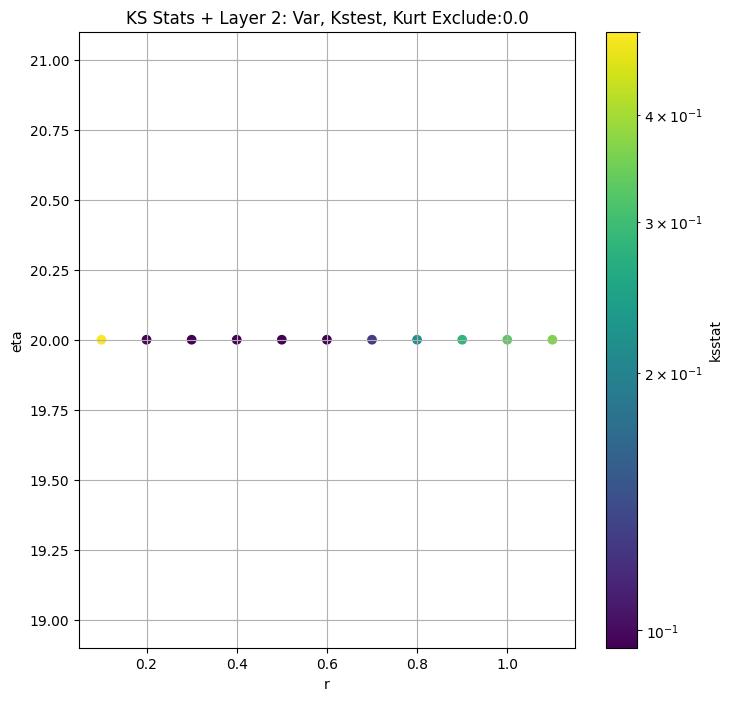

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.05815087848942391 5192923.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.05813164072051458 4673814.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.05814234238737748 4354319.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.05813332473735078 4095576.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.058181788034422255 3876298.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.058861825358819786 3509532.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.05999609466648226 3200022.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.0625628852023461 2932447.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.07176365951821695 2697272.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.0807185855755771 2490793.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.10497700134521093 1981344.0
Number of samples: 6416, Without approximation : 6416.0


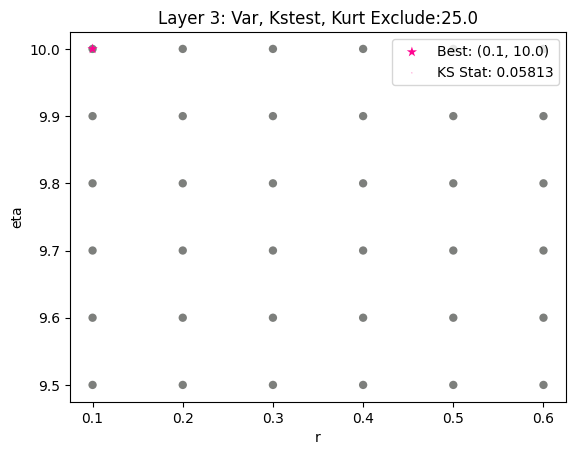

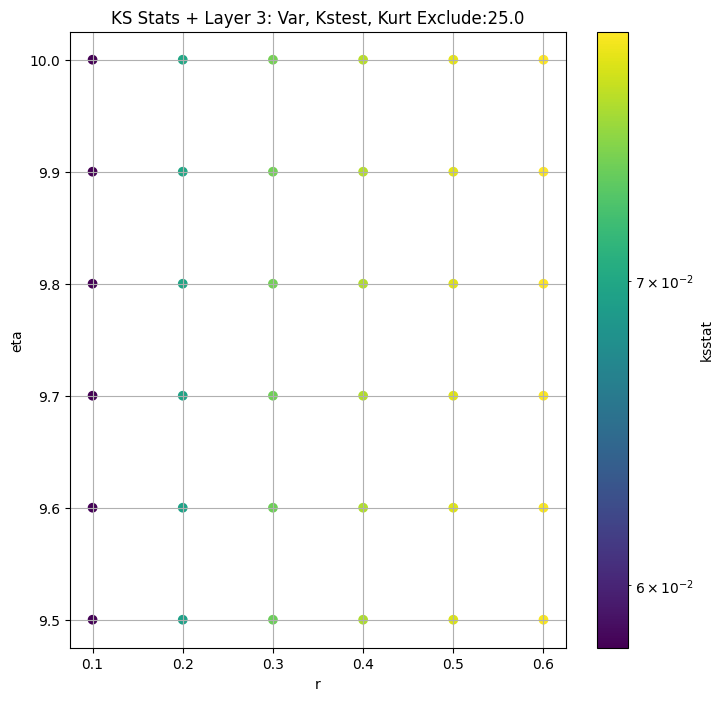

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.045829454833986816 1119893.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0457772401804481 1063397.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.045745452473872905 1024895.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.04586763549620654 993598.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.04583717253698377 966337.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.04591701201955567 918420.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.04605319613522374 878126.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.04601325994575722 842552.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.04640624901881252 810388.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.046956580346557586 780940.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.048273385841905825 704925.75
Number of samples: 25664, Without approximation : 25664.0


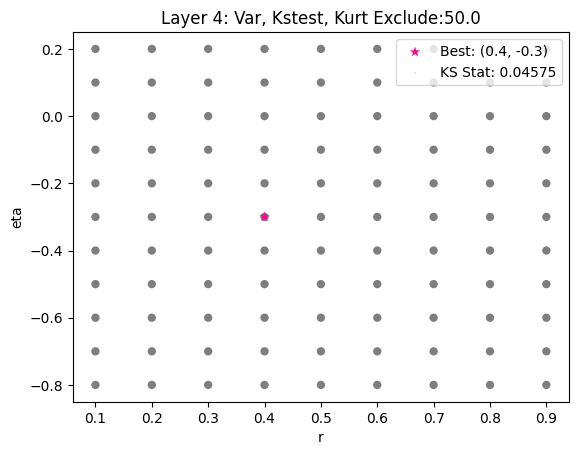

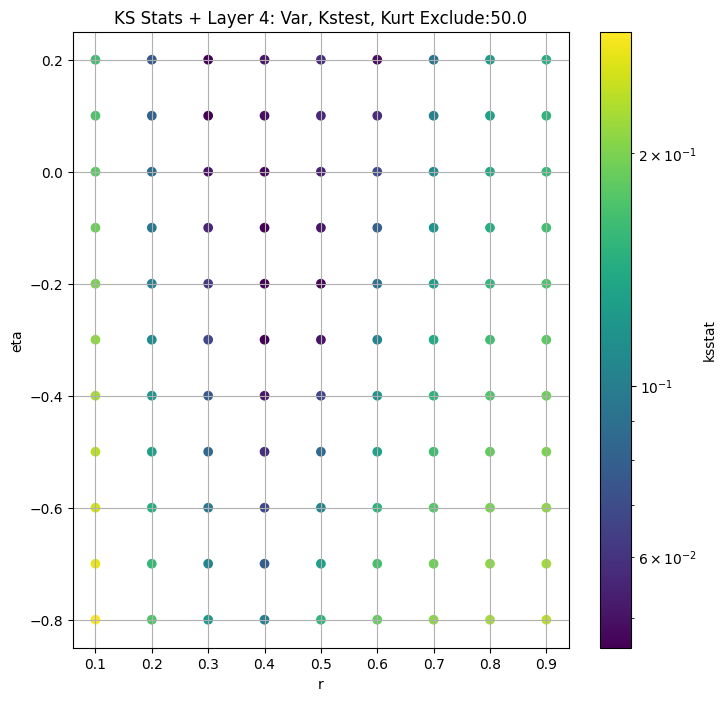

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0343604320139394 209451.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.034168910141777475 205304.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.034019280839933 202146.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03388623700802168 199395.73


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03381016555389249 196906.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.033796332313108135 192396.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03378340859828788 188320.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0337712195469807 184591.58


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03375957534167773 181131.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.033748410078761226 177902.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03371691907013197 169166.92
Number of samples: 100000, Without approximation : 102656.0


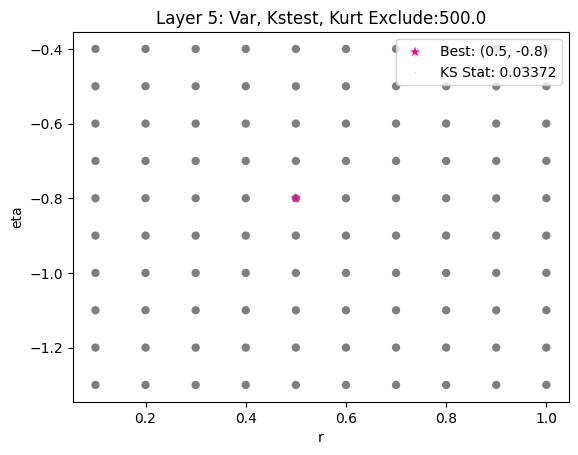

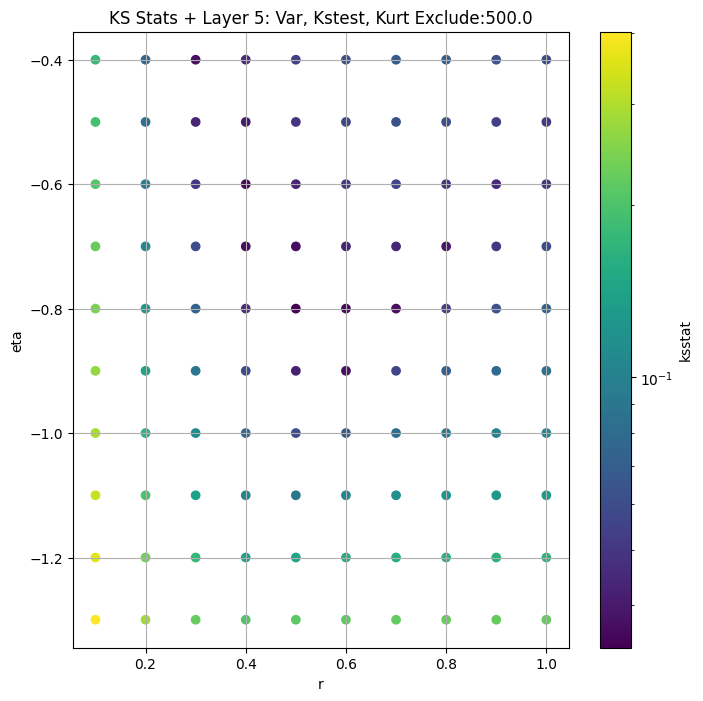

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.03646146458055505 37873.188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.0363565256207799 36846.625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.03627404337142137 36066.51


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.036435275406205836 35383.953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.036717010933290384 34768.57


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.037234045401628 33676.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.037356765273558024 32715.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.037487916119739506 31845.988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.03701936302440928 31047.354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.03693023233480225 30307.826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.03667979279818667 28357.023
Number of samples: 100000, Without approximation : 410624.0


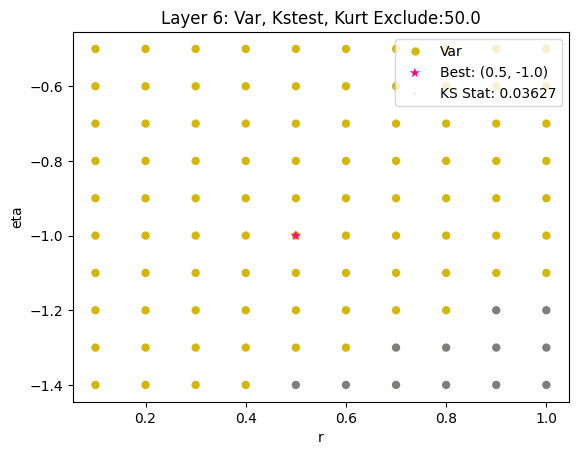

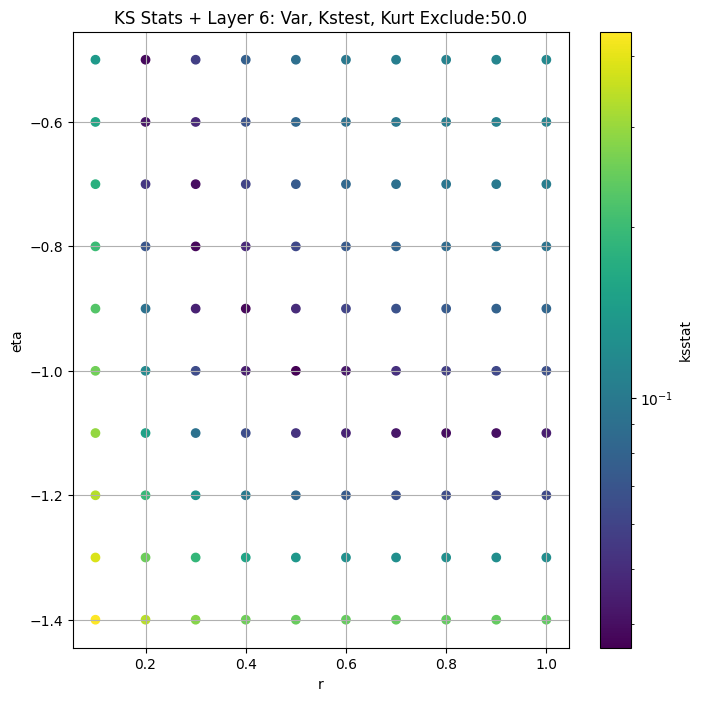

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.03755210381803853 6625.385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.037599669920063805 6378.9653


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.03830259399073227 6196.8296


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.03805117263719915 6041.407


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.03782570035704497 5903.775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.037418989497850996 5664.606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.03813102777657246 5459.319


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.037797285244678736 5276.277


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.03748154406300713 5109.902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.03802343572696831 4957.2666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.03788523341592648 4563.9185
Number of samples: 100000, Without approximation : 1642496.0


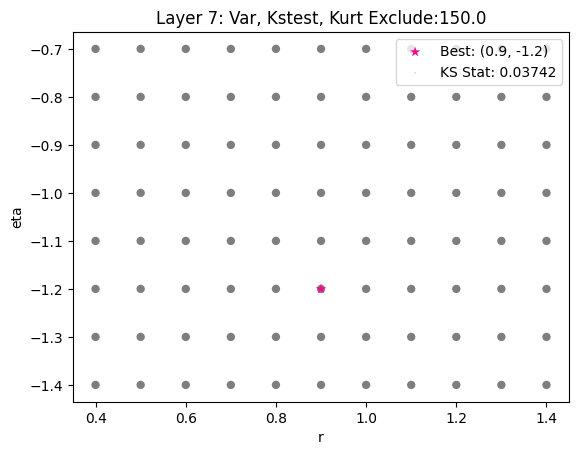

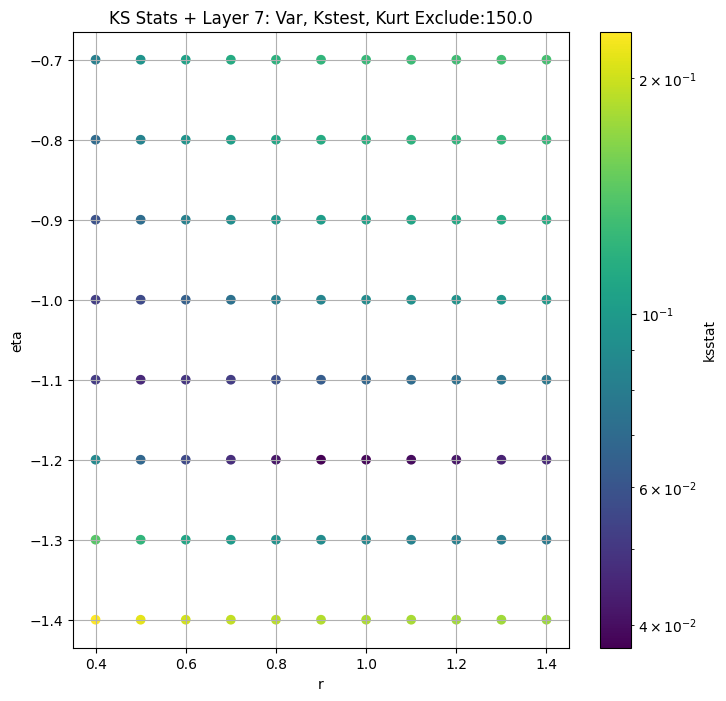

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.018776938145611655 1253.6875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.017416649948026497 1190.2421


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.016896113405560187 1145.294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.017785550107621284 1107.4884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01863323113117943 1074.4115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.020162793739273543 1017.8314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.021550171058084322 969.8668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.022783493073656957 928.03394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.022231238917387763 890.83826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.02171367688125625 857.3466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.019066303885636654 773.01544
Number of samples: 100000, Without approximation : 6569984.0


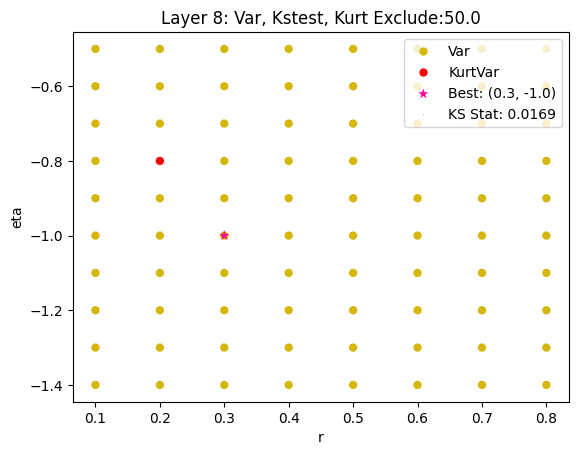

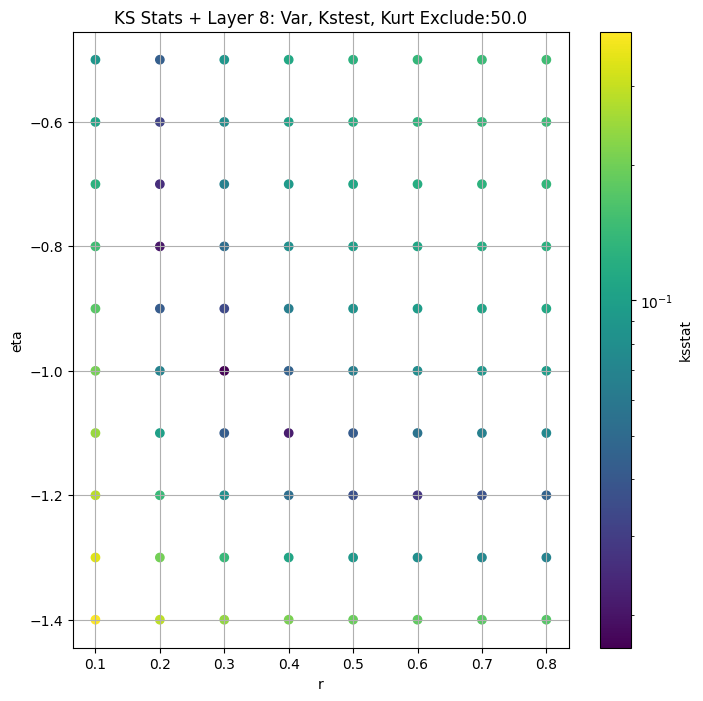

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.01606420393579311 269.56787


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.015400810885760952 252.73573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.014221393275365923 241.11441


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.013193408348221969 231.48164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.012275994419621794 223.13972


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.012348982182795731 209.05057


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.011491814738240458 197.33482


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.011883355849964361 187.29382


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01226968839978071 178.50017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.013160230013724017 170.68103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.01720961261435827 151.41641
Number of samples: 100000, Without approximation : 26279936.0


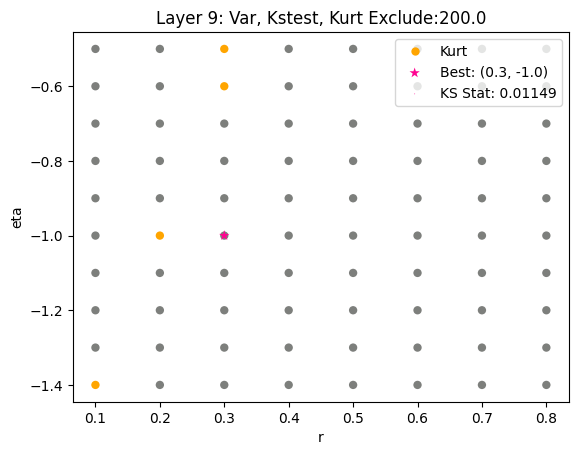

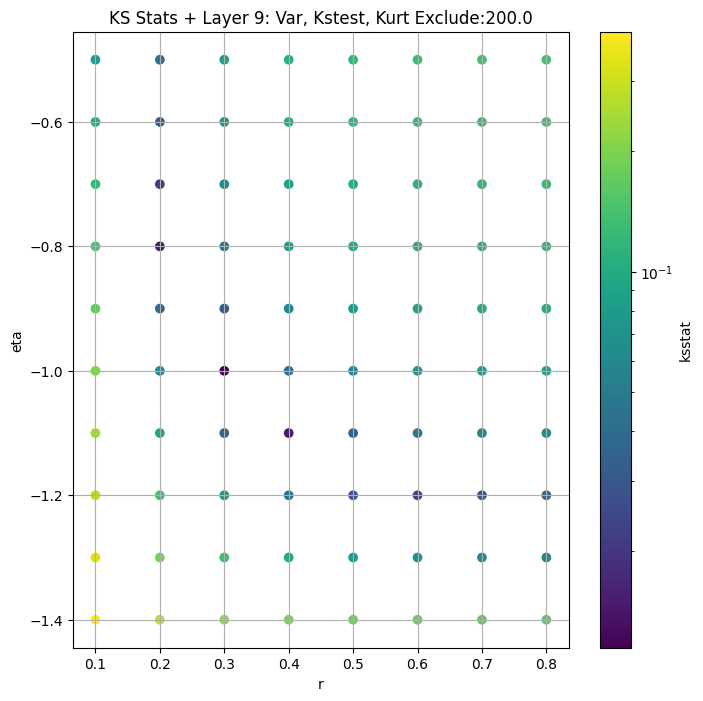

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.407840e+07  2.168831e+07  2.656773e+07   0.461436    0.050193   
3      5.192924e+06  4.881462e+06  5.512114e+06   1.550051    1.186425   
4      1.119893e+06  1.053084e+06  1.188511e+06   3.461348    2.873582   
5      2.094513e+05  1.953325e+05  2.241483e+05   5.254725    4.462294   
6      3.787319e+04  3.475236e+04  4.113391e+04   8.857376    7.467968   
7      6.625385e+03  5.973334e+03  7.328550e+03  13.585444   11.134627   
8      1.253688e+03  1.105452e+03  1.416207e+03  20.776464   16.477352   
9      2.695679e+02  2.335772e+02  3.089436e+02  27.743181   21.335247   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.936050         1604.0             0.095449        0.6         20.0   
3        1.950193         6416.0             0.058132        0.1         10.0   
4        4.113647        25664.0             0.045745        0.4         -0.3   
5        6.151662       102656.0             0.033717        0.5         -0.8   
6       10.460917       410624.0             0.036274        0.5         -1.0   
7       16.512316      1642496.0             0.037419        0.9         -1.2   
8       26.031052      6569984.0             0.016896        0.3         -1.0   
9       36.427760     26279936.0             0.011492        0.3         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.088185e+04                     0.0        2.407840e+07   
3       7.893099e-15                    25.0        4.673814e+06   
4       3.916090e+04                    50.0        1.024895e+06   
5       5.034730e+04                   500.0        1.691669e+05   
6       1.803326e+04                    50.0        3.606651e+04   
7       1.713290e+04                   150.0        5.664606e+03   
8       4.307953e+01                    50.0        1.145294e+03   
9       7.422628e+00                   200.0        1.973348e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.13112755021823008, var: 12836806.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.12012284814813812, var: 14567449.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.10953154625896305, var: 16611822.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.10207772343921367, var: 19274358.0


  0%|          | 0/99 [00:00<?, ?it/s]

Finding Minimum after computing 99 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.09541375078591097, var: 24078400.0
Number of samples: 1604, Without approximation : 1604.0


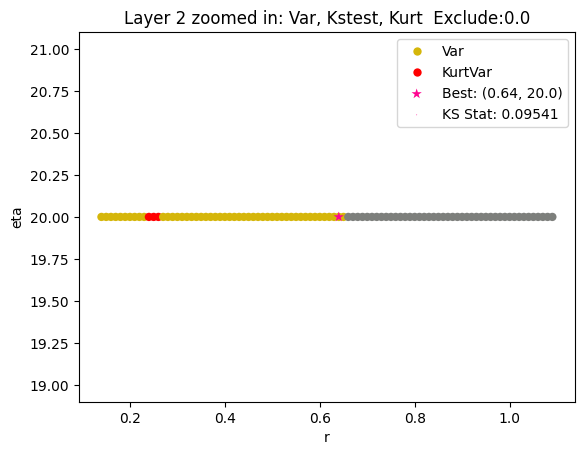

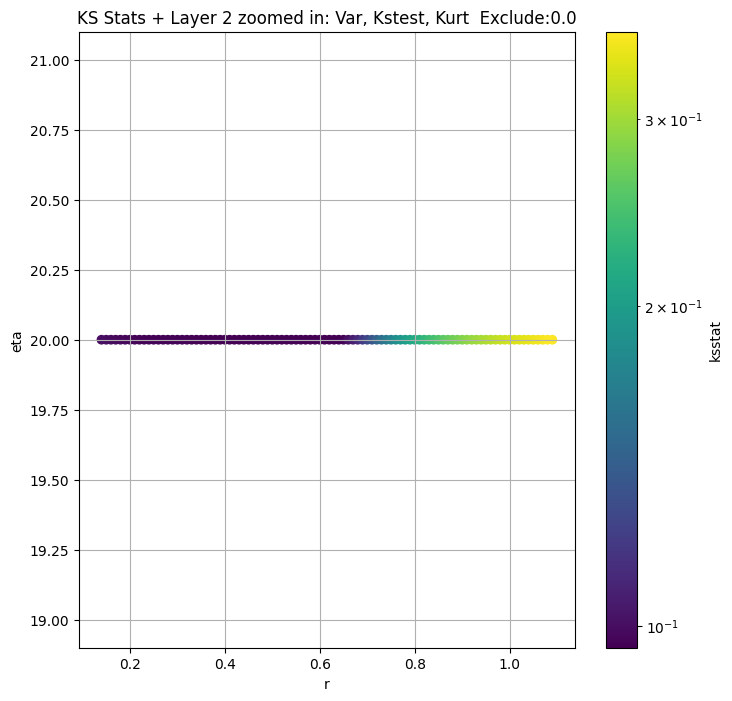

Layer 3


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
layer 3, 25.0 + 100 = 125, ksstat: 0.05870859716719545, var: 3683788.0


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
layer 3, 25.0 + 75 = 100, ksstat: 0.05848460923863902, var: 3876298.75


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
layer 3, 25.0 + 50 = 75, ksstat: 0.05824051330943192, var: 4095576.5


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
layer 3, 25.0 + 25 = 50, ksstat: 0.0581740398216809, var: 4354319.5


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
layer 3, 25.0 + 0 = 25, ksstat: 0.05813164072051458, var: 4673814.5


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
layer 3, 25.0 + -25 = 0, ksstat: 0.0582657508933741, var: 5192923.5
Number of samples: 6416, Without approximation : 6416.0


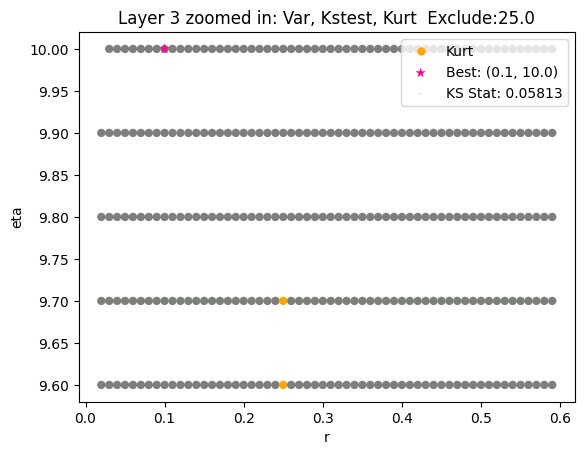

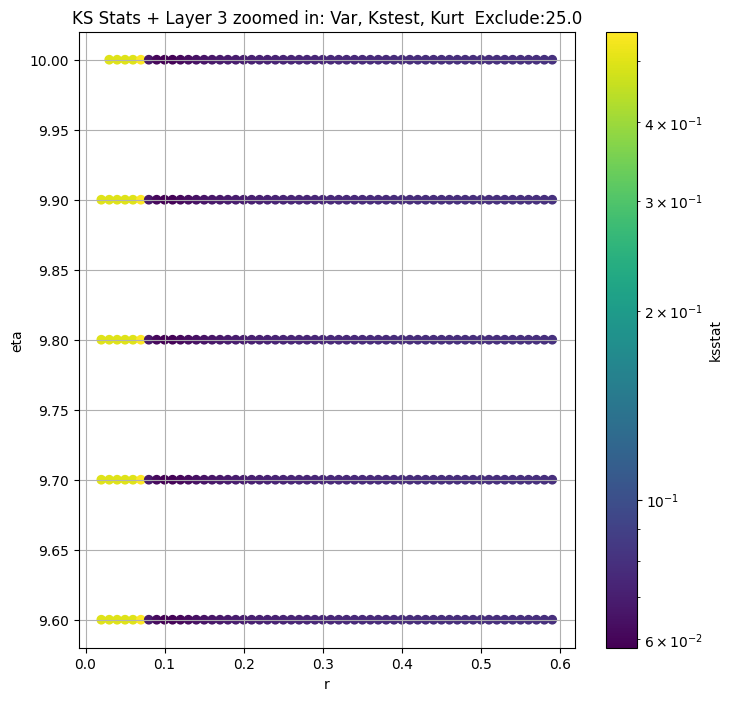

Layer 4


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 100 = 150, ksstat: 0.04581999020076272, var: 918420.1875


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 75 = 125, ksstat: 0.045784809974345086, var: 941150.6875


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 50 = 100, ksstat: 0.045780845157946615, var: 966337.8125


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 25 = 75, ksstat: 0.04571233972408012, var: 993598.25


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + 0 = 50, ksstat: 0.0457123687434462, var: 1024895.125


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + -25 = 25, ksstat: 0.04571571368341554, var: 1063397.75


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 4, 50.0 + -50 = 0, ksstat: 0.04568879015159871, var: 1119893.0
Number of samples: 25664, Without approximation : 25664.0


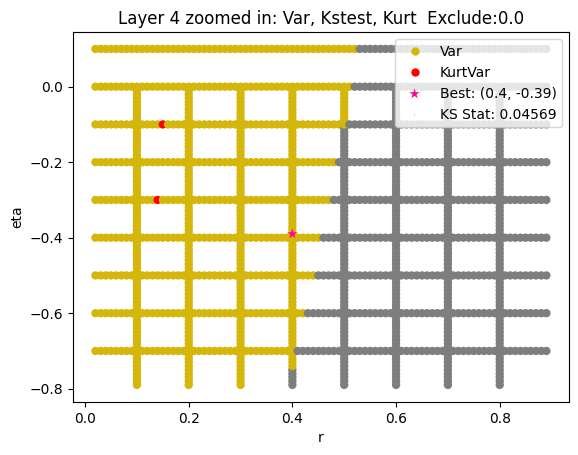

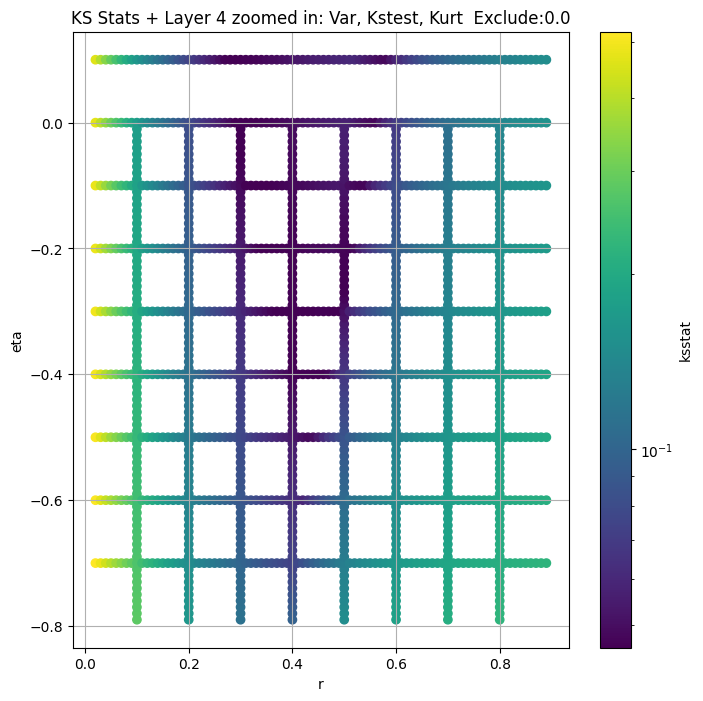

Layer 5


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 100 = 600, ksstat: 0.03357351369086381, var: 164008.828125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 75 = 575, ksstat: 0.03357351369086381, var: 165255.828125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 50 = 550, ksstat: 0.03357351369086381, var: 166531.59375


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 25 = 525, ksstat: 0.03357351369086381, var: 167835.875


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + 0 = 500, ksstat: 0.03357351369086381, var: 169166.921875


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -25 = 475, ksstat: 0.03357351369086381, var: 170535.328125


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -50 = 450, ksstat: 0.03357351369086381, var: 171940.921875


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -75 = 425, ksstat: 0.03357351369086381, var: 173381.65625


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 5, 500.0 + -100 = 400, ksstat: 0.03357351369086381, var: 174856.53125
Number of samples: 100000, Without approximation : 102656.0


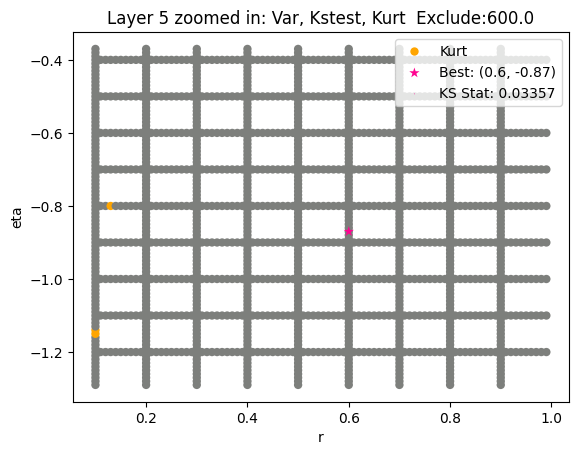

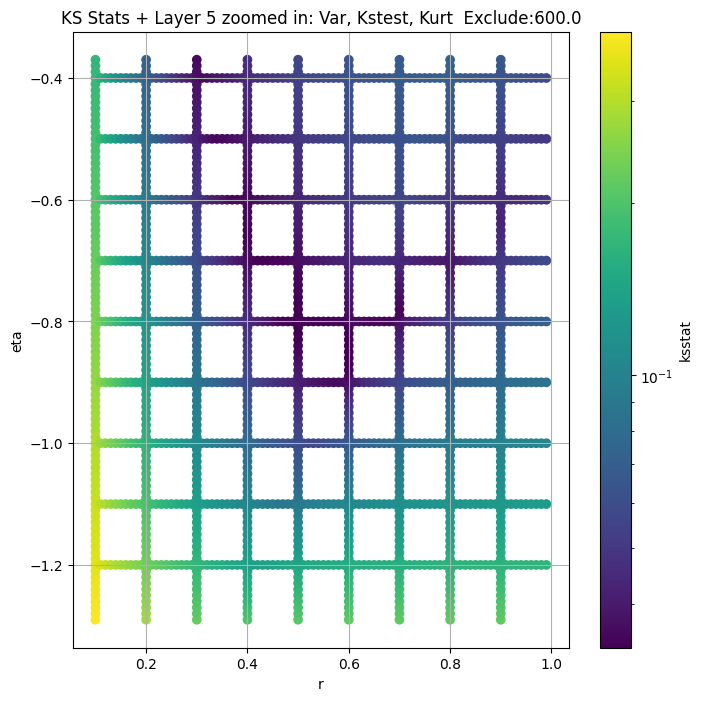

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.03599297061191664, var: 33676.23046875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.03603973231211066, var: 34203.2578125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.03610310523524046, var: 34768.5703125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.03617045810656172, var: 35383.953125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.03627404337142137, var: 36066.51171875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.03595649166747439, var: 36846.625


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.03629685546282457, var: 37873.1875
Number of samples: 100000, Without approximation : 410624.0


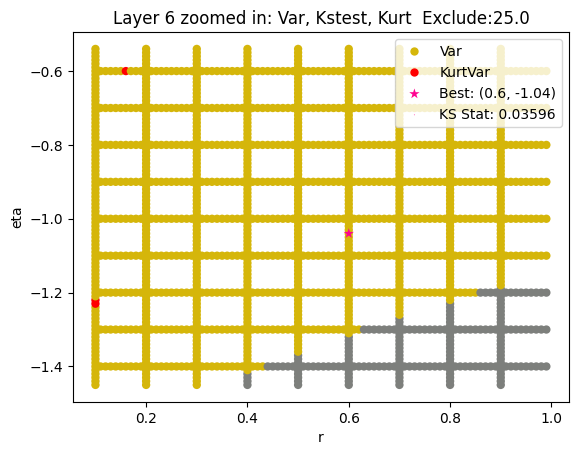

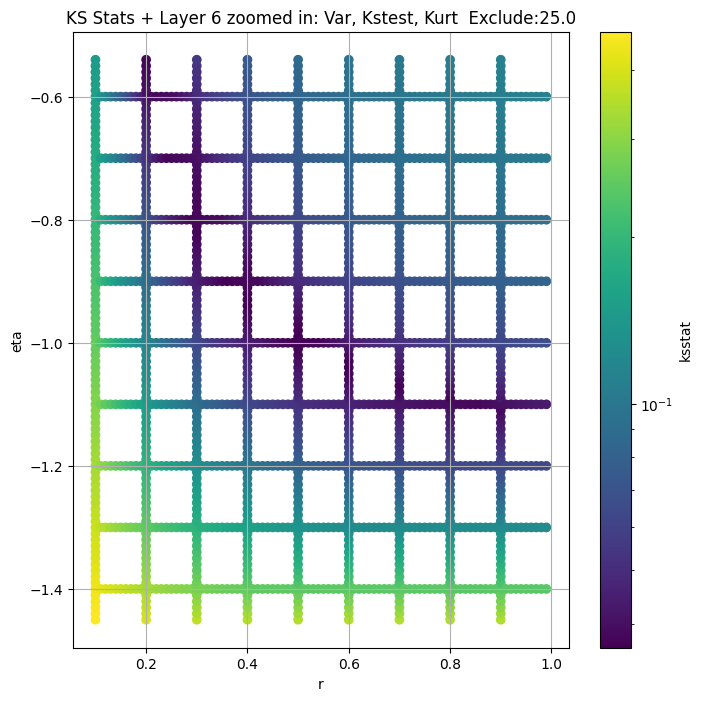

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.03687315065672514, var: 5276.27685546875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.03634407874718881, var: 5365.4912109375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.036656676061406546, var: 5459.31884765625


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.03658281350103687, var: 5558.62255859375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.0366652281715838, var: 5664.60595703125


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.03699919224017889, var: 5779.0029296875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.036447690624710594, var: 5903.77490234375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.03668388438866754, var: 6041.4072265625


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.03679900021964888, var: 6196.82958984375
Number of samples: 100000, Without approximation : 1642496.0


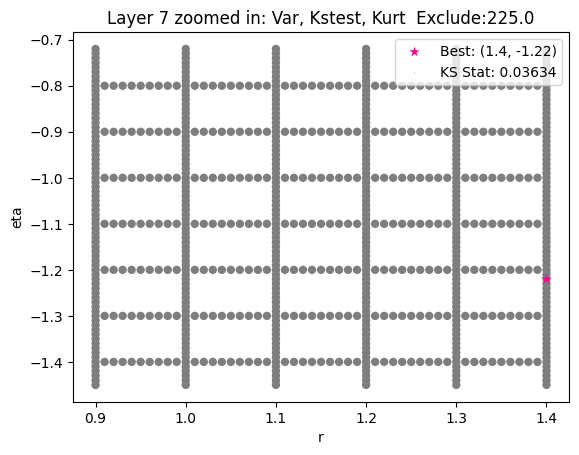

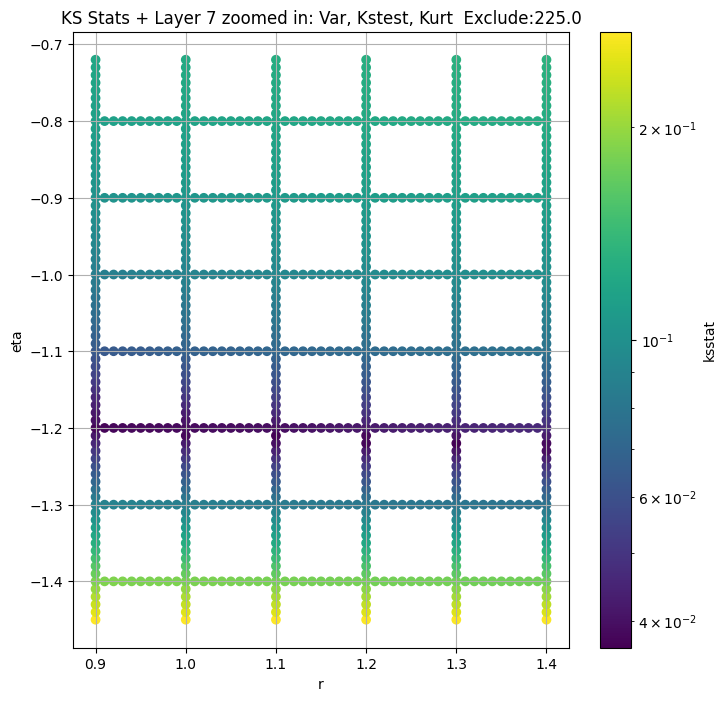

Layer 8


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.017462679143966375, var: 1017.8314208984375


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.017101531448298735, var: 1044.81201171875


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.01731045186791874, var: 1074.4114990234375


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.01772063444490607, var: 1107.4884033203125


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.016896113405560187, var: 1145.2939453125


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.017416649948026497, var: 1190.2420654296875


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.016794603941645003, var: 1253.6875
Number of samples: 100000, Without approximation : 6569984.0


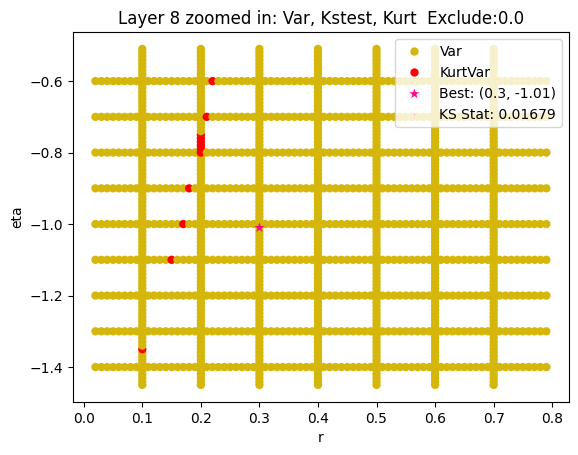

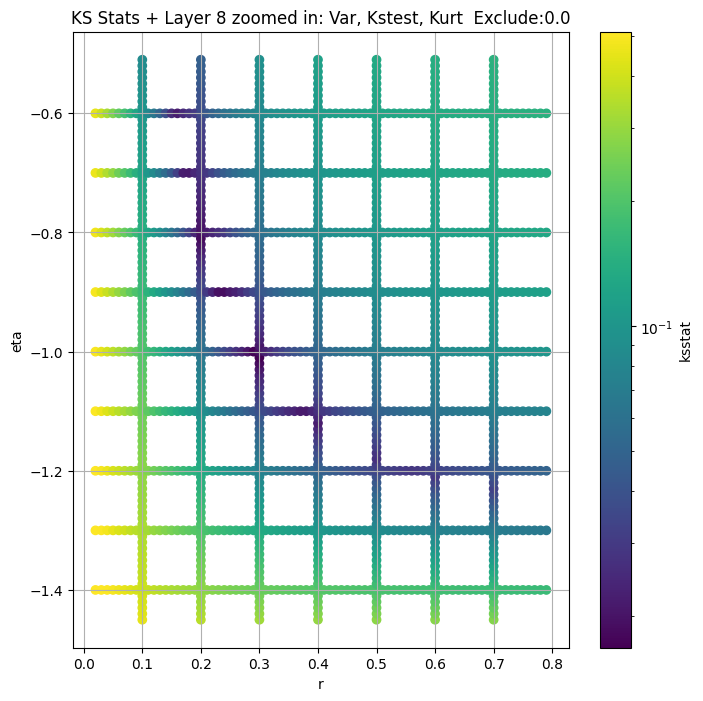

Layer 9


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.011329189458611832, var: 178.5001678466797


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.0112454591718123, var: 182.7611083984375


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.011461175266719248, var: 187.2938232421875


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.011688743169880222, var: 192.1346893310547


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.010845946212455049, var: 197.33482360839844


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.011155142480742342, var: 202.95130920410156


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.011901522631666106, var: 209.05056762695312


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.011442868839009857, var: 215.7324981689453


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.011034227408598496, var: 223.1397247314453
Number of samples: 100000, Without approximation : 26279936.0


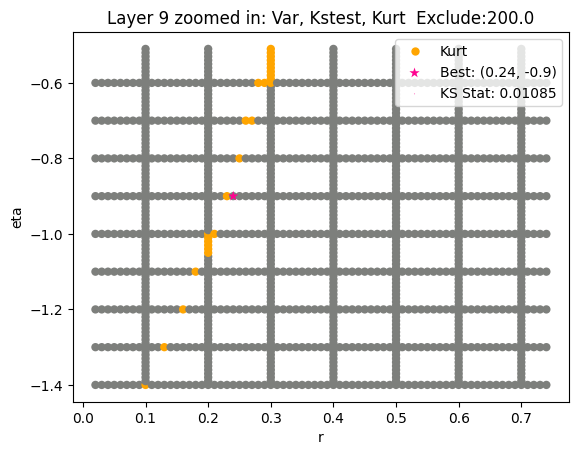

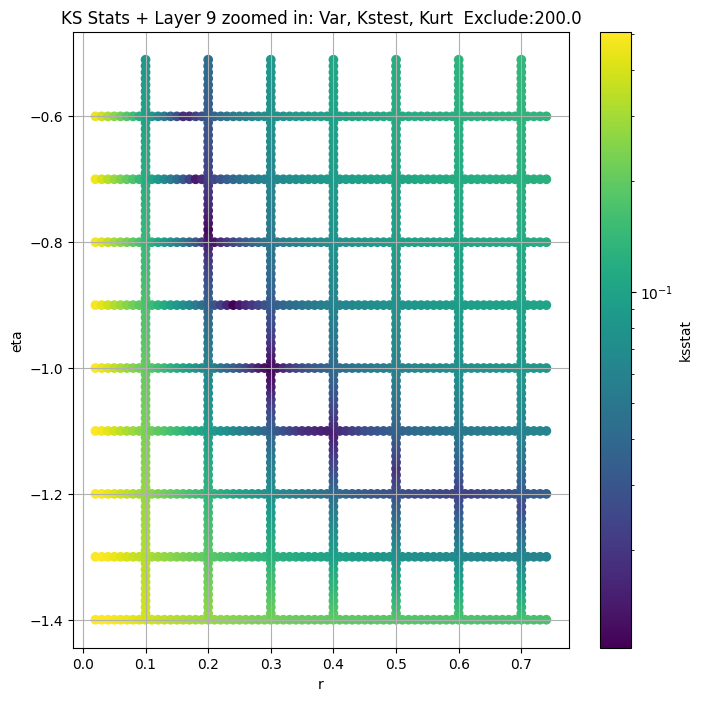

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.407840e+07  2.168831e+07  2.656773e+07   0.461436    0.050193   
3      5.192924e+06  4.881462e+06  5.512114e+06   1.550051    1.186425   
4      1.119893e+06  1.053084e+06  1.188511e+06   3.461348    2.873582   
5      2.094513e+05  1.953325e+05  2.241483e+05   5.254725    4.462294   
6      3.787319e+04  3.475236e+04  4.113391e+04   8.857376    7.467968   
7      6.625385e+03  5.973334e+03  7.328550e+03  13.585444   11.134627   
8      1.253688e+03  1.105452e+03  1.416207e+03  20.776464   16.477352   
9      2.695679e+02  2.335772e+02  3.089436e+02  27.743181   21.335247   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.936050         1604.0             0.095449        0.6         20.0   
3        1.950193         6416.0             0.058132        0.1         10.0   
4        4.113647        25664.0             0.045745        0.4         -0.3   
5        6.151662       102656.0             0.033717        0.5         -0.8   
6       10.460917       410624.0             0.036274        0.5         -1.0   
7       16.512316      1642496.0             0.037419        0.9         -1.2   
8       26.031052      6569984.0             0.016896        0.3         -1.0   
9       36.427760     26279936.0             0.011492        0.3         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.088185e+04                     0.0        2.407840e+07   
3       7.893099e-15                    25.0        4.673814e+06   
4       3.916090e+04                    50.0        1.119893e+06   
5       5.034730e+04                   500.0        1.640088e+05   
6       1.803326e+04                    50.0        3.684662e+04   
7       1.713290e+04                   150.0        5.365491e+03   
8       4.307953e+01                    50.0        1.253688e+03   
9       7.422628e+00                   200.0        1.973348e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.095414    0.64     20.00   
3                     0.016929          0.058132    0.10     10.00   
4                     0.008471          0.045689    0.40     -0.39   
5                     0.004237          0.033574    0.60     -0.87   
6                     0.002119          0.035956    0.60     -1.04   
7                     0.001060          0.036344    1.40     -1.22   
8                     0.000530          0.016795    0.30     -1.01   
9                     0.000265          0.010846    0.24     -0.90   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      9.800015e+04                  0.0          200  
3      7.893099e-15                 25.0          567  
4      5.021788e+04                  0.0          901  
5      1.000000e+05                600.0         1604  
6      3.493150e+04                 25.0         1353  
7      2.329562e+04                225.0         1353  
8      4.930146e+01                  0.0         6416  
9      6.742972e-01                200.0        16240

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

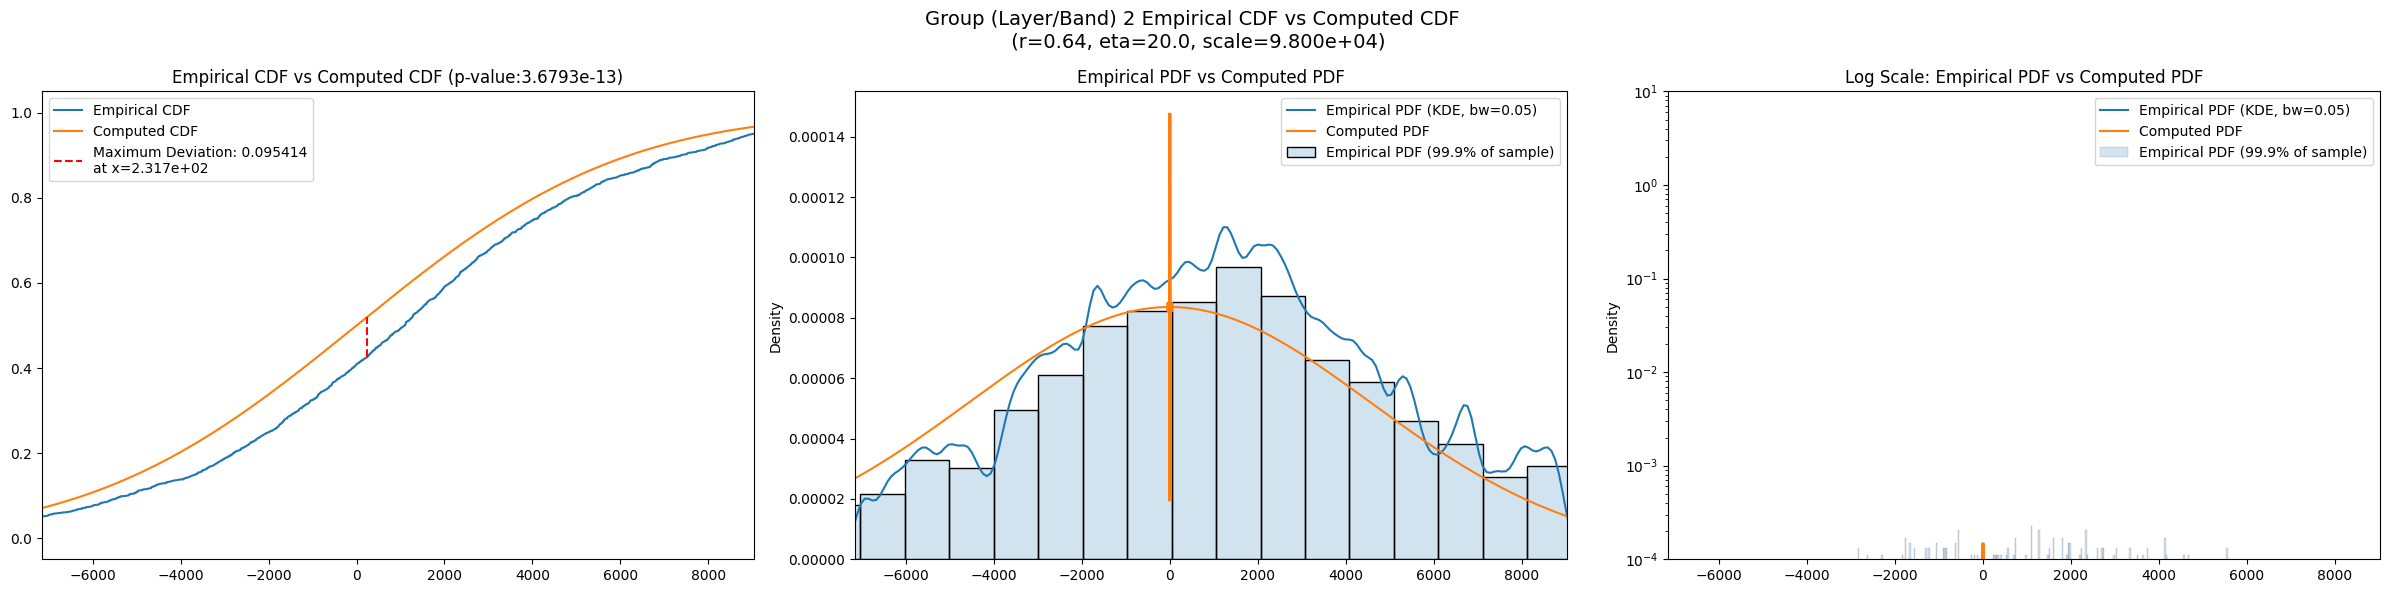

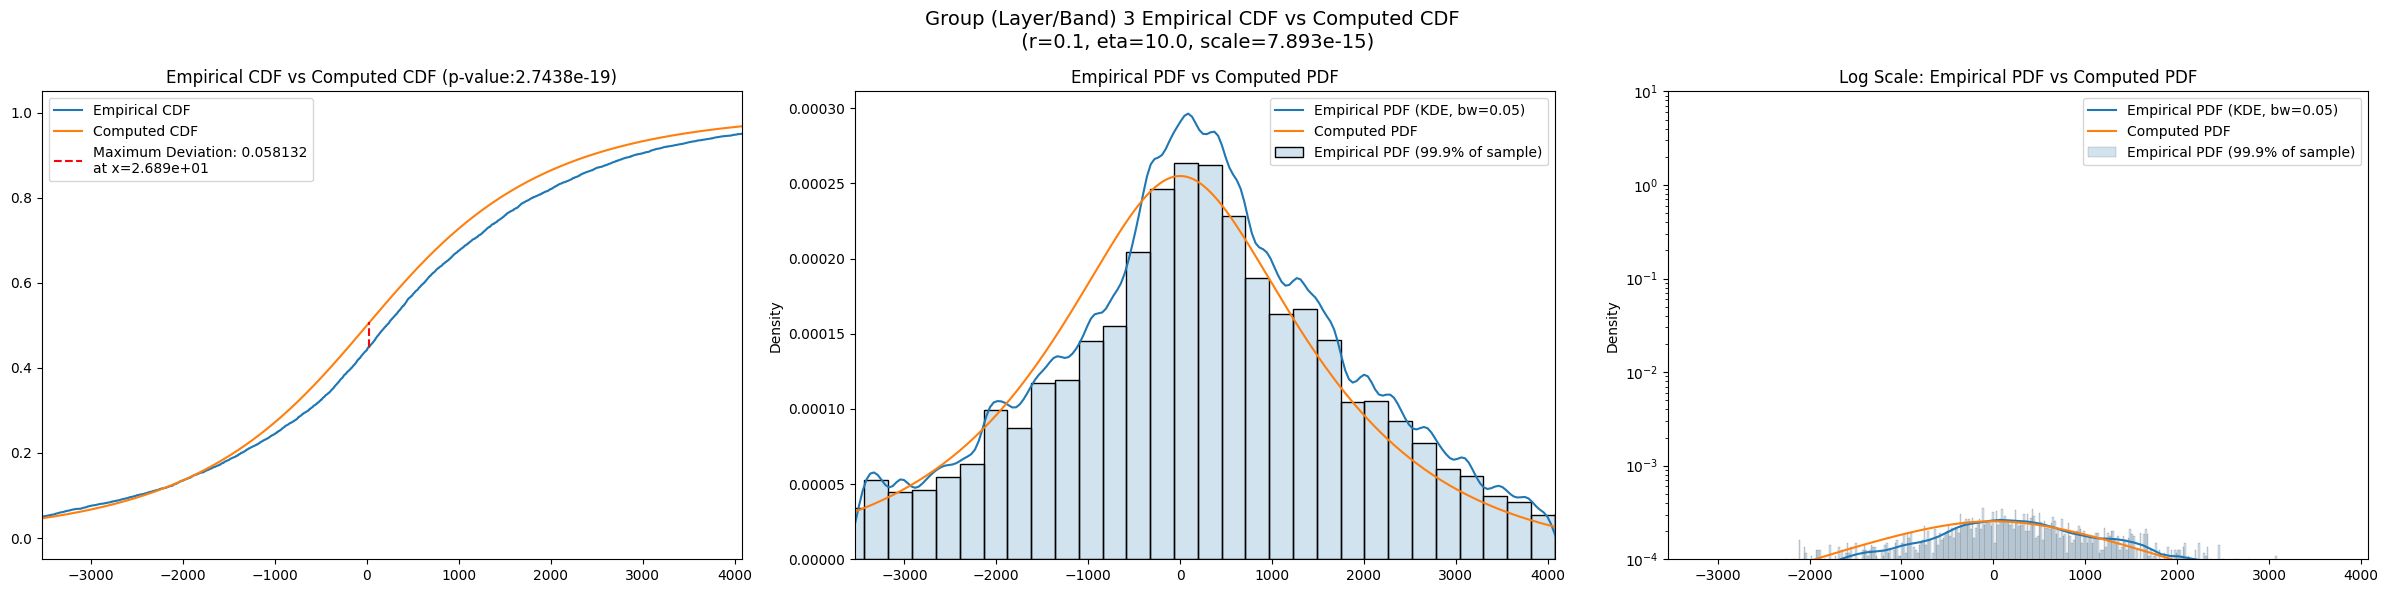

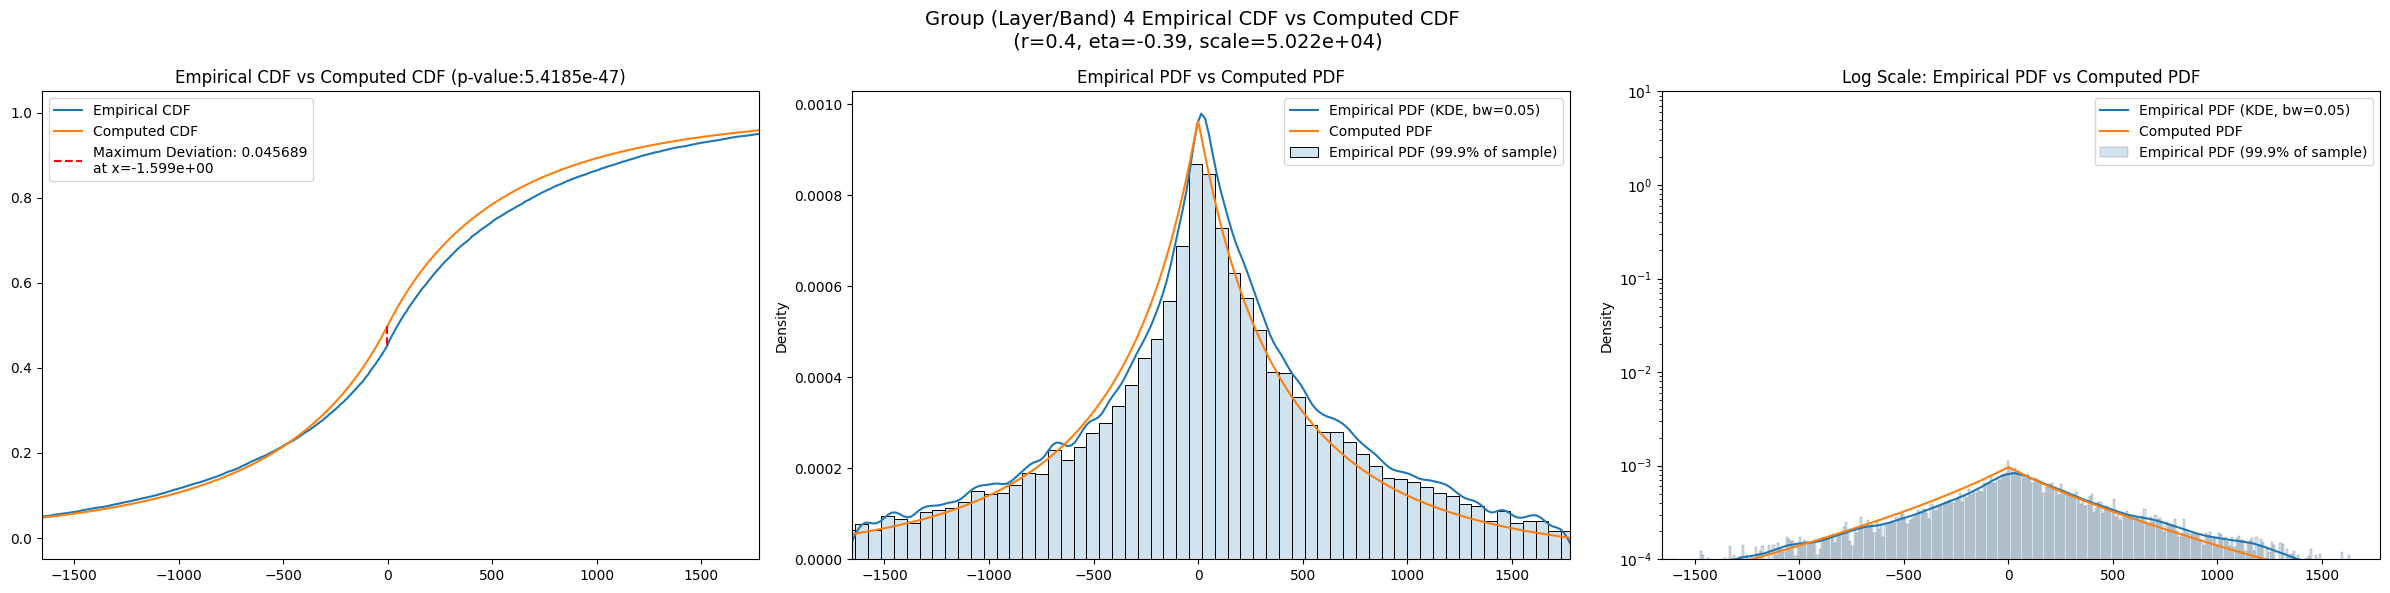

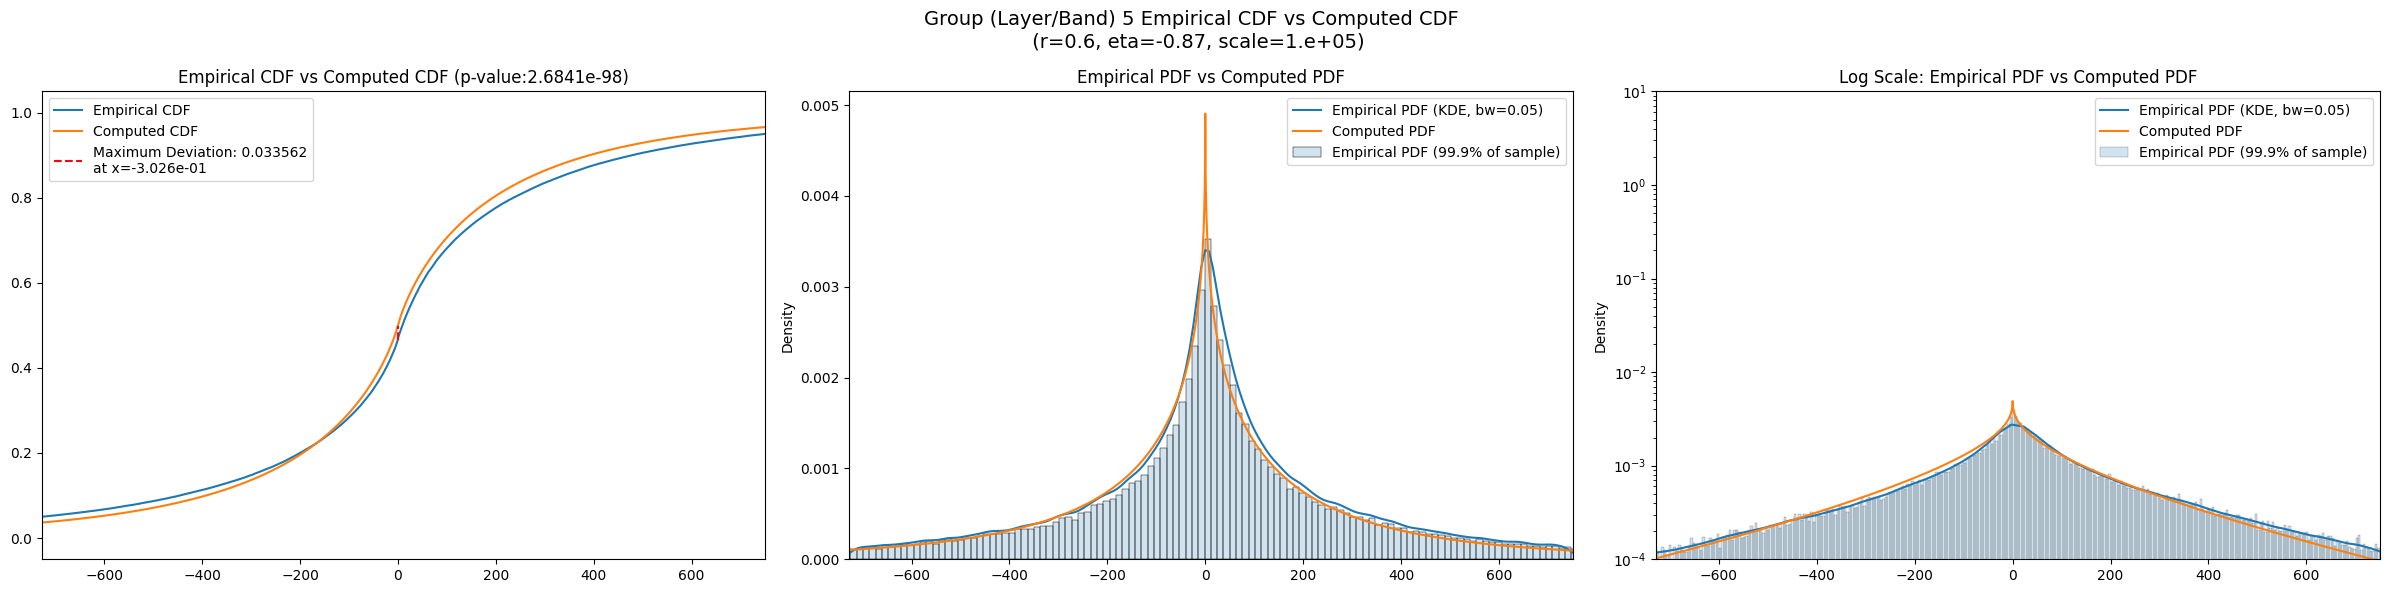

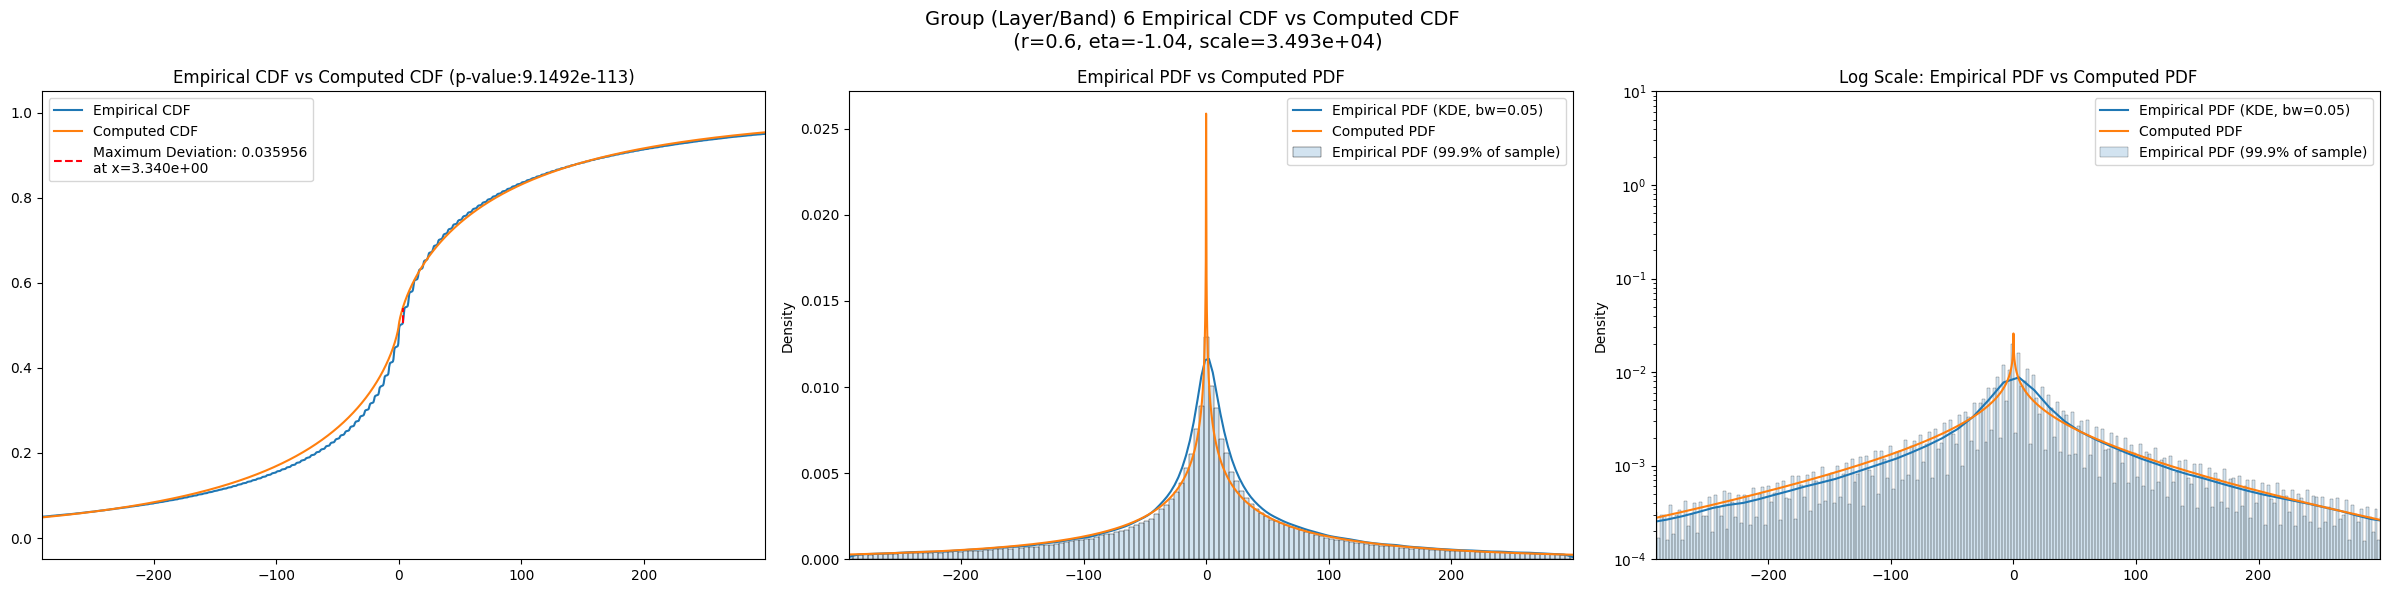

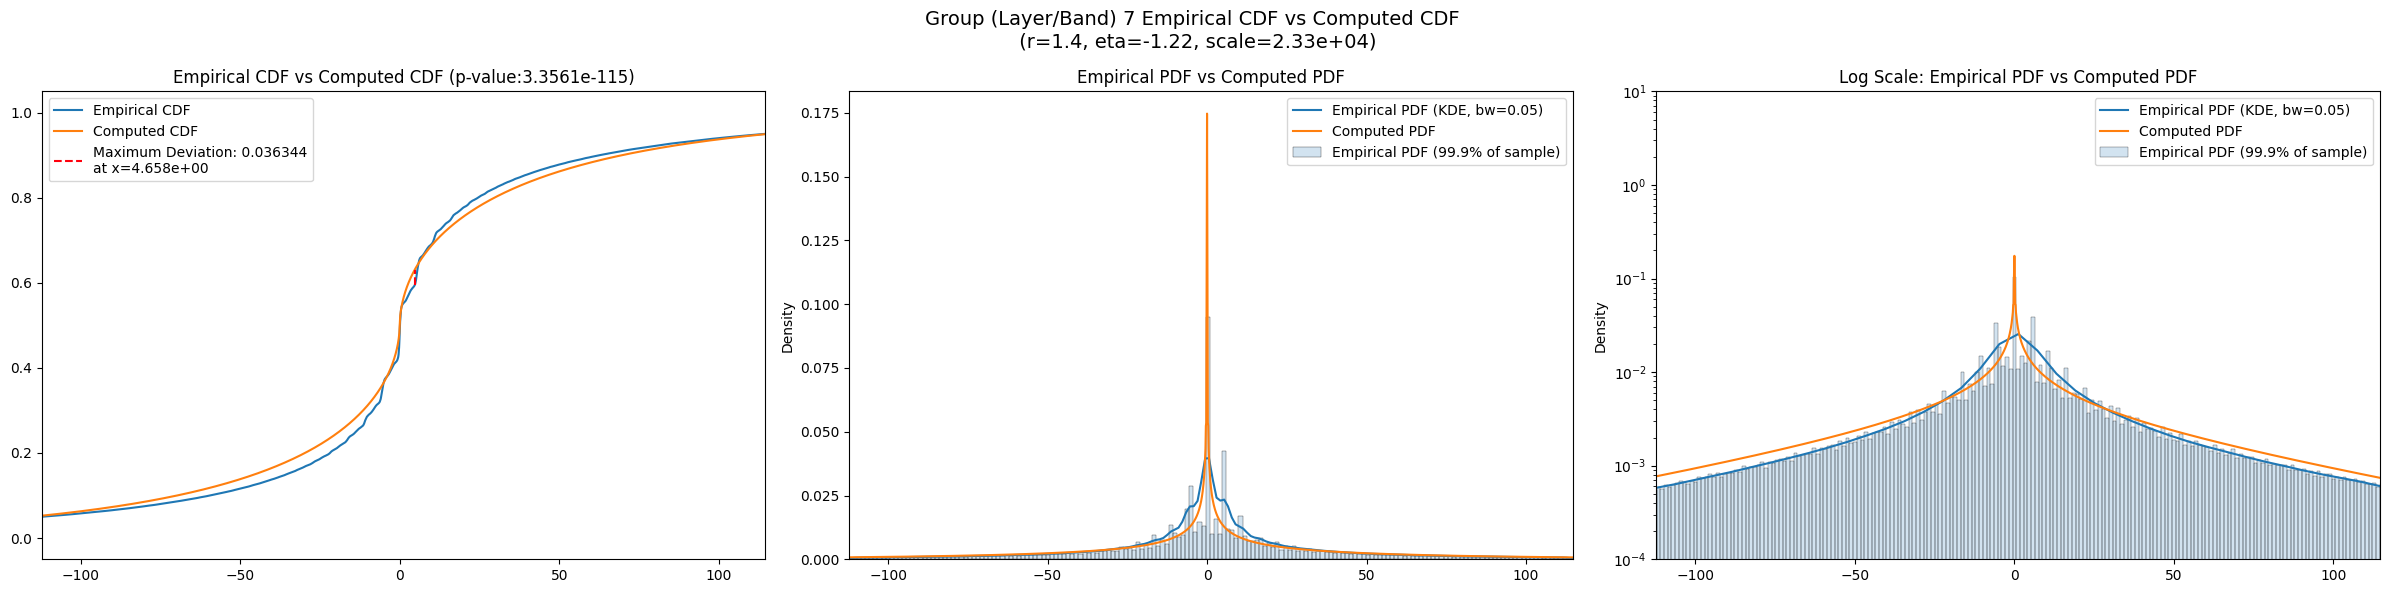

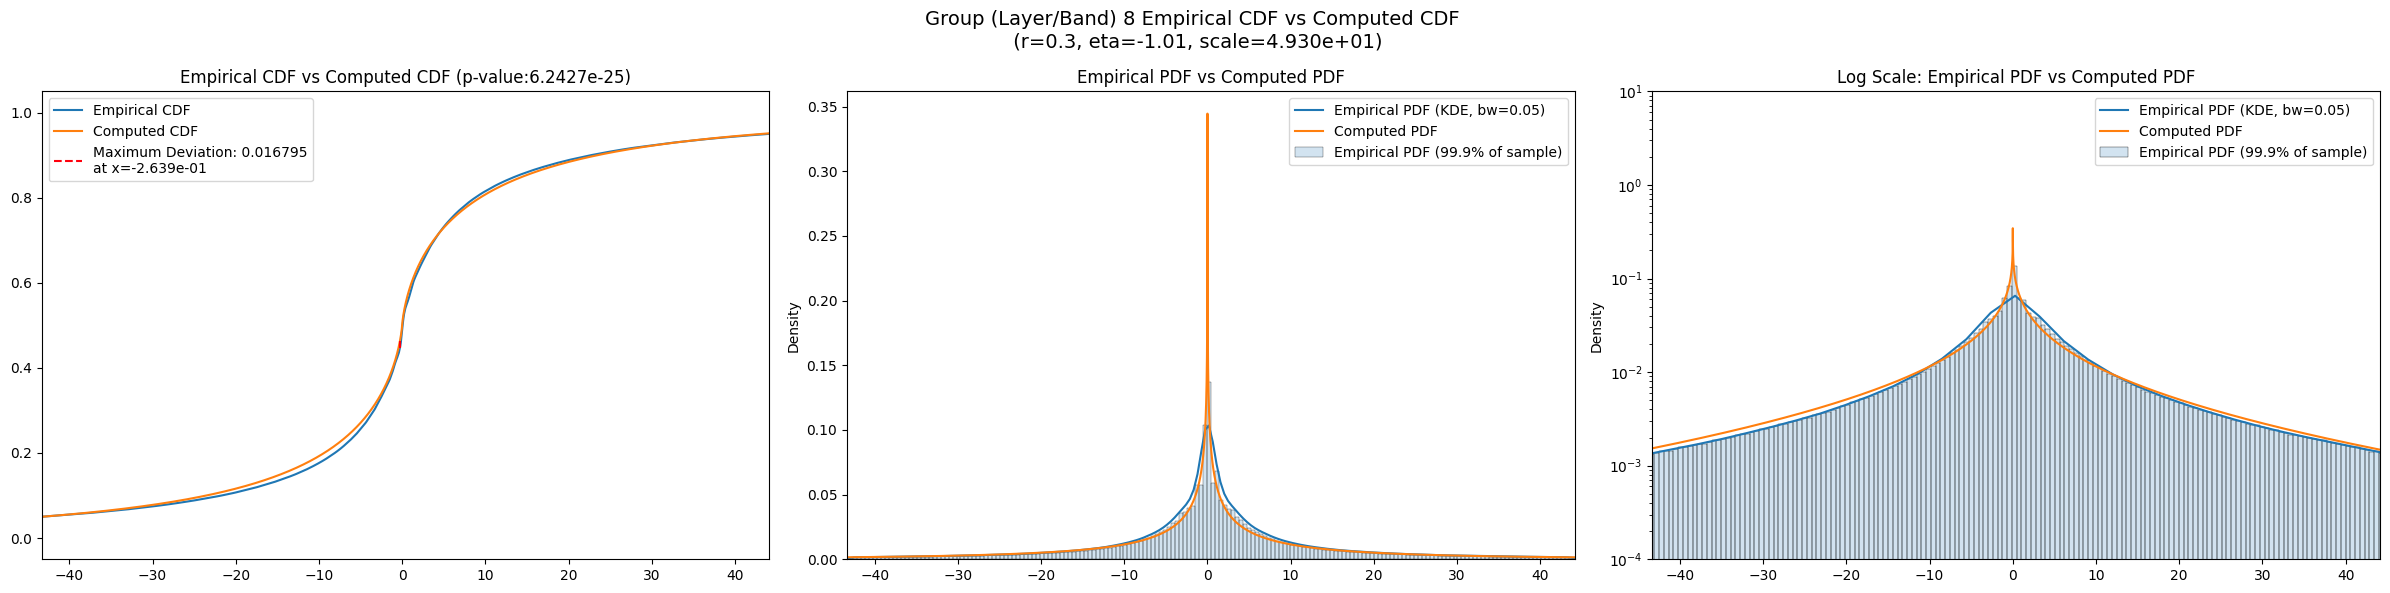

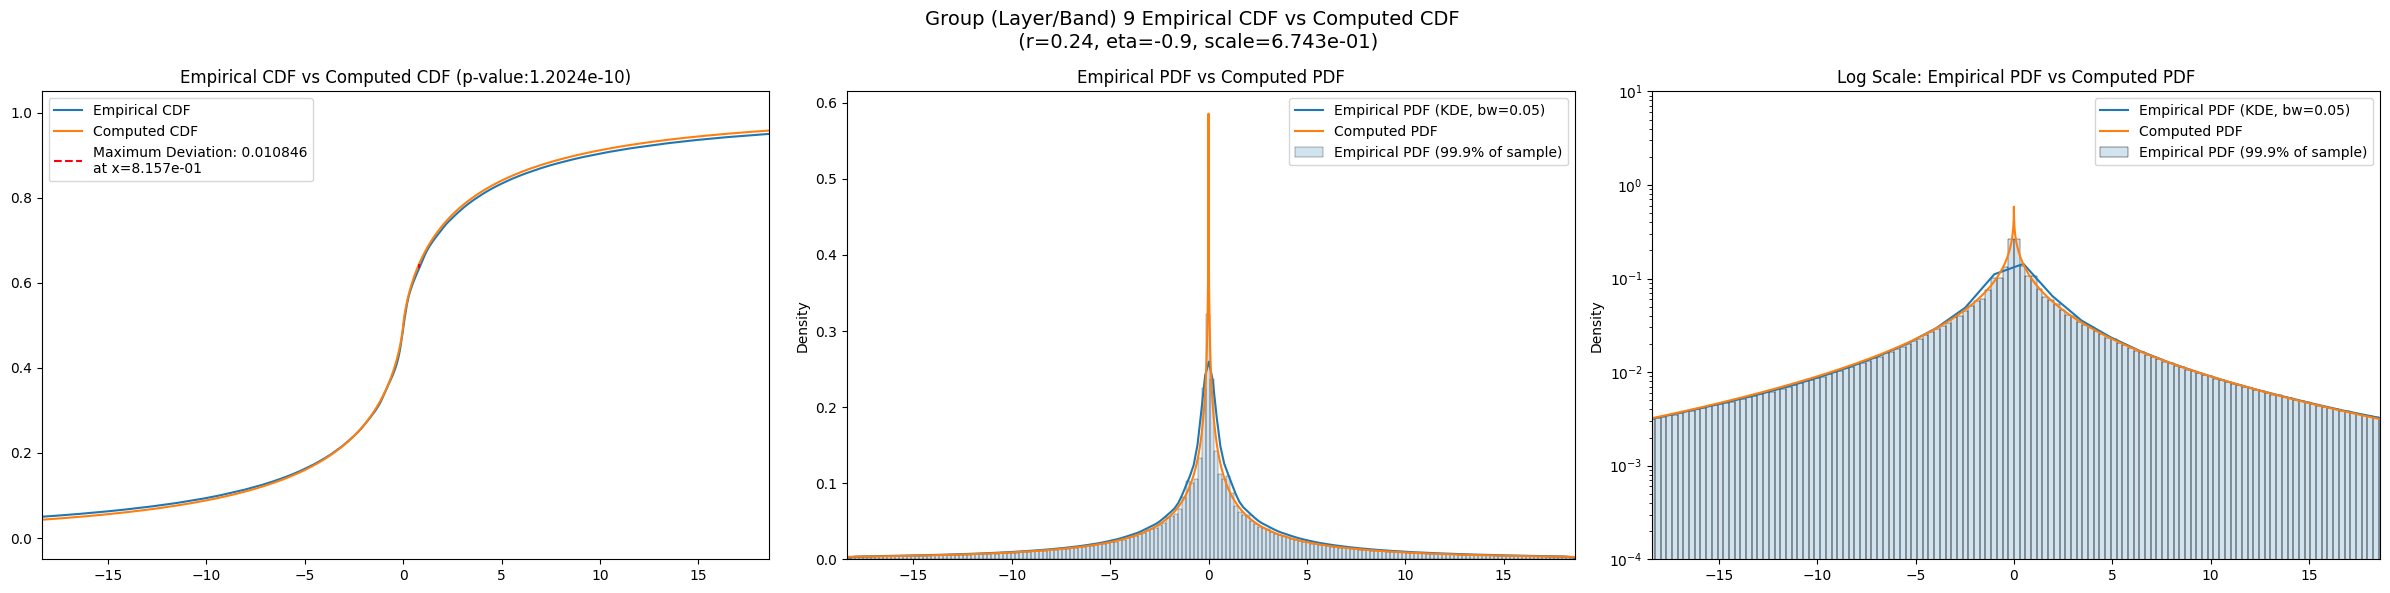

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      2.407840e+07  2.168831e+07  2.656773e+07   0.461436    0.050193   
3      5.192924e+06  4.881462e+06  5.512114e+06   1.550051    1.186425   
4      1.119893e+06  1.053084e+06  1.188511e+06   3.461348    2.873582   
5      2.094513e+05  1.953325e+05  2.241483e+05   5.254725    4.462294   
6      3.787319e+04  3.475236e+04  4.113391e+04   8.857376    7.467968   
7      6.625385e+03  5.973334e+03  7.328550e+03  13.585444   11.134627   
8      1.253688e+03  1.105452e+03  1.416207e+03  20.776464   16.477352   
9      2.695679e+02  2.335772e+02  3.089436e+02  27.743181   21.335247   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.936050         1604.0             0.095449        0.6         20.0   
3        1.950193         6416.0             0.058132        0.1         10.0   
4        4.113647        25664.0             0.045745        0.4         -0.3   
5        6.151662       102656.0             0.033717        0.5         -0.8   
6       10.460917       410624.0             0.036274        0.5         -1.0   
7       16.512316      1642496.0             0.037419        0.9         -1.2   
8       26.031052      6569984.0             0.016896        0.3         -1.0   
9       36.427760     26279936.0             0.011492        0.3         -1.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       4796.4500              0.095324          3.887840e-13   
3      ...       1695.8200              0.062880          1.697930e-22   
4      ...        694.5350              0.063587          1.181420e-90   
5      ...        252.3060              0.071688          0.000000e+00   
6      ...         83.6688              0.083276          0.000000e+00   
7      ...         27.6505              0.090233          0.000000e+00   
8      ...         11.0941              0.080382          0.000000e+00   
9      ...          4.6049              0.081932          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         5201.02000             0.097868         7.971540e-14  4204.62000   
3         1847.96000             0.058501         1.576920e-19  1387.21000   
4          591.39700             0.045939         1.666090e-47   502.51800   
5          214.14300             0.047538        4.857530e-202   174.42200   
6           71.09430             0.058624         0.000000e+00    56.17240   
7           23.47230             0.066064         0.000000e+00    18.28760   
8            9.61610             0.055524         0.000000e+00     7.31925   
9            4.02471             0.056103         0.000000e+00     3.08522   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.095528   3.428980e-13          3.679294e-13  
3           0.058131   2.747220e-19          2.743766e-19  
4           0.049969   3.957450e-56          5.418972e-47  
5           0.052492  2.793970e-246         5.758060e-101  
6           0.061490   0.000000e+00          0.000000e+00  
7           0.067182   0.000000e+00          0.000000e+00  
8           0.056118   0.000000e+00          0.000000e+00  
9           0.056667   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.095449                 0.033804          0.095414   
3                 0.058132                 0.016929          0.058132   
4                 0.045745                 0.008471          0.045689   
5                 0.033717                 0.004237          0.033574   
6                 0.036274                 0.002119          0.035956   
7                 0.037419                 0.001060          0.036344   
8                 0.016896                 0.000530          0.016795   
9                 0.011492                 0.000265          0.010846   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.095324             0.097868       0.095528  
3                  0.062880             0.058501       0.058131  
4                  0.063587             0.045939       0.049969  
5                  0.071688             0.047538       0.052492  
6                  0.083276             0.058624       0.061490  
7                  0.090233             0.066064       0.067182  
8                  0.080382             0.055524       0.056118  
9                  0.081932             0.056103       0.056667

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            2.407840e+07          0.095414    0.64     20.00  9.800015e+04   
3            4.673814e+06          0.058132    0.10     10.00  7.893099e-15   
4            1.119893e+06          0.045689    0.40     -0.39  5.021788e+04   
5            1.640088e+05          0.033574    0.60     -0.87  1.000000e+05   
6            3.684662e+04          0.035956    0.60     -1.04  3.493150e+04   
7            5.365491e+03          0.036344    1.40     -1.22  2.329562e+04   
8            1.253688e+03          0.016795    0.30     -1.01  4.930146e+01   
9            1.973348e+02          0.010846    0.24     -0.90  6.742972e-01   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                     25.0  
4                      0.0  
5                    600.0  
6                     25.0  
7                    225.0  
8                      0.0  
9                    200.0

In [21]:
eng.quit()